In [1]:
# Import the package
import pandas as pd
import numpy as np
from pydrf.model import DRFModel 
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn.tree
from treefarms import TREEFARMS
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pydrf.order import CategoryOrderEncoder


In [2]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
# data (as pandas dataframes) 
car_X = car_evaluation.data.features 
car_y = car_evaluation.data.targets 


In [6]:
# len(X.columns)
for i in car_X.columns:
    temp = car_X.copy()
    temp[i] = car_X[i].astype(str)
X = temp

In [7]:

# X['buying'] = X['buying'].astype(str)
# X['maint'] = X['maint'].astype(str)
# X['lug_boot'] = X['lug_boot'].astype(str)
# X['safety'] = X['safety'].astype(str)
# X['doors'] = X['doors'].astype(str)
# X['persons'] = X['persons'].astype(str)
# # y['class'] = y['class'].astype(str)

In [8]:
# X.columns[]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(['acc', 'good', 'unacc', 'vgood'])
y= le.transform(car_y)
np.unique(y)

/opt/miniconda3/envs/Pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([0, 1, 2, 3])

In [9]:
# category encoder
encoder = CategoryOrderEncoder()
categories =  X.columns[X.dtypes== "object"]
encoder.fit(X, y, categories)
X = encoder.transform(X)
y = np.ravel(y)

In [10]:
y

array([2, 2, 2, ..., 2, 1, 3])

In [26]:
# Define the structure of DRF
param_list = [
    [{"max_leaf_nodes":6, "n_estimators":100, "max_features":0.8}],
    [{"max_leaf_nodes":6, "n_estimators":100, "max_features":0.8}],
    [{"max_leaf_nodes":6, "n_estimators":100, "max_features":0.8}],
    [{"max_leaf_nodes":6, "n_estimators":100, "max_features":0.8}],
    [{"max_leaf_nodes":6, "n_estimators":100, "max_features":0.8}]
    ]

# Fit the model
drf = DRFModel(parallel_cores=5, parameter_list = param_list)
drf_model = drf.fit(X, y)


Layer 0 training...finished.
Layer 1 training...finished.
Layer 2 training...finished.
Layer 3 training...finished.
Layer 4 training...finished.


In [27]:
# 5th layer + decision tree as empirical risk minimizer model
transform_train = drf_model.transform_data(X.values, stop_layer = 5)
standard_tree = DecisionTreeClassifier(max_depth=2)
standard_tree.fit(transform_train, y)


Transforming data...finished.


DecisionTreeClassifier(max_depth=2)

In [28]:
print(standard_tree.score(transform_train,y))

0.8952546296296297


0.26989937905878675
0.2968893169646655


[Text(0.6, 0.8333333333333334, 'x[29] <= 5.5\ngini = 0.457\nsamples = 1728\nvalue = [384, 69, 1210, 65]'),
 Text(0.4, 0.5, 'x[24] <= 2.5\ngini = 0.518\nsamples = 576\nvalue = [384, 69, 58, 65]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.35\nsamples = 432\nvalue = [343, 20, 56, 13]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.673\nsamples = 144\nvalue = [41, 49, 2, 52]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 1152\nvalue = [0, 0, 1152, 0]')]

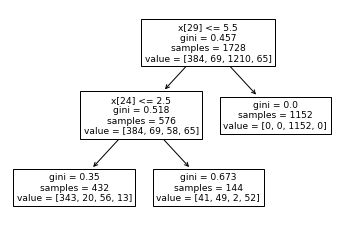

In [29]:
from sklearn.metrics import log_loss
standard = log_loss(y, standard_tree.predict_proba(transform_train))
print(standard)
print(standard*1.1)
sklearn.tree.plot_tree(standard_tree)

In [30]:
# m = drf_model.model_[1][0]
# sklearn.tree.plot_tree(m)


In [31]:
# m.score(transform_train, y)

In [32]:
# loss_list < standard*1.1 # 先對這些做篩選，看有幾個屬於R set
# transform_train = drf_model.transform_data(X.values, stop_layer = 4)
# score_list = [tree.score(transform_train, y) for tree in drf_model.model_[4]]
# print("max accuracy", max(score_list))

In [33]:
layer = 4
transform_train = drf_model.transform_data(X.values, stop_layer = layer)
loss_list = [log_loss(y, tree.predict_proba(transform_train)) for tree in drf_model.model_[layer]]
print("number under threshold", sum(loss_list < standard * 1.1 ))
print("mean loss:", np.mean(loss_list))
score_list = [tree.score(transform_train, y) for tree in drf_model.model_[layer]]
print("max accuracy", max(score_list))

Transforming data...finished.
number under threshold 98
mean loss: 0.22987926473090348
max accuracy 0.9259259259259259


In [34]:
layer = 3
transform_train = drf_model.transform_data(X.values, stop_layer = layer)
loss_list = [log_loss(y, tree.predict_proba(transform_train)) for tree in drf_model.model_[layer]]
print("number under threshold",sum(loss_list < standard*1.1 ))
print("mean loss:", np.mean(loss_list ))
score_list = [tree.score(transform_train, y) for tree in drf_model.model_[layer]]
print("max accuracy",max(score_list))

Transforming data...finished.
number under threshold 99
mean loss: 0.23295186010263177
max accuracy 0.9259259259259259


In [35]:
layer = 2
transform_train = drf_model.transform_data(X.values, stop_layer = layer)
loss_list = [log_loss(y, tree.predict_proba(transform_train)) for tree in drf_model.model_[layer]]
print("number under threshold",sum(loss_list < standard*1.1 ))
print("mean loss:", np.mean(loss_list ))
score_list = [tree.score(transform_train, y) for tree in drf_model.model_[layer]]
print("max accuracy",max(score_list))

Transforming data...finished.
number under threshold 97
mean loss: 0.24588331389922222
max accuracy 0.9259259259259259


In [36]:
layer = 1
transform_train = drf_model.transform_data(X.values, stop_layer = layer)
loss_list = [log_loss(y, tree.predict_proba(transform_train)) for tree in drf_model.model_[layer]]
print("number under threshold",sum(loss_list < standard*1.1 ))
print("mean loss:", np.mean(loss_list ))
score_list = [tree.score(transform_train, y) for tree in drf_model.model_[layer]]
print("max accuracy",max(score_list))

Transforming data...finished.
number under threshold 63
mean loss: 0.2996728375096264
max accuracy 0.9039351851851852


In [37]:
layer = 0
transform_train = drf_model.transform_data(X.values, stop_layer = layer)
loss_list = [log_loss(y, tree.predict_proba(transform_train)) for tree in drf_model.model_[layer]]
print("number under threshold",sum(loss_list < standard*1.1 ))
print("mean loss:", np.mean(loss_list ))
score_list = [tree.score(transform_train, y) for tree in drf_model.model_[layer]]
print("max accuracy",max(score_list))

Transforming data...finished.
number under threshold 0
mean loss: 0.4235890083738601
max accuracy 0.8402777777777778
